# LGBM을 활용한 베이스라인

In [46]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [54]:
data_dir = '/opt/ml/input/data/'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [55]:
import pandas as pd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime

def convert_time2timestamp(t):
    timestamp = time.mktime(t.timetuple())
    return int(timestamp)

def convert_string2datetime(s: str):
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S")

def fe(df):
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    ## 문자열로 인식되는 Timestamp의 타입을 datetime으로 변경하기. 
    df["Timestamp"] = df["Timestamp"].apply(convert_string2datetime) # string type to datetime type


    ## 기본적인 시간정보 추가
    df['year'] = df['Timestamp'].dt.year
    df['month'] = df['Timestamp'].dt.month
    df['day'] = df['Timestamp'].dt.day
    df['hour'] = df['Timestamp'].dt.hour                                       # 시간대로 범주 추가 가능


    ## 요일 추가
    df['wday'] = df['Timestamp'].dt.weekday # Monday ~ Sunday => 0 ~ 6         # 주말로 범주 추가 가능
    

    ## 문제를 다시 풀어본 횟수 feature 'retry' 추가
    test_group = df.groupby(['userID','testId']) # 같은 시험지끼리 묶어준다.
    # retry_check = 0
    retry_df = pd.DataFrame()
    for key, group in test_group:
        if len(group[group.assessmentItemID == group.assessmentItemID.iloc[0]]) >= 2:
            retry_df = pd.concat([retry_df,group.groupby('assessmentItemID').cumcount()])
            # retry_check += 1
    retry_df.columns=['retry']
    df = pd.merge(df, retry_df, left_index=True,right_index=True, how="left")
    df['retry'] = df['retry'].fillna(0) # retry의 결측치(한 번만 푼 문제들)을 0으로 바꿔준다.

    
    ## 문제 풀이 시간 추가
    df['time'] = df['time'] = df.groupby(['userID','testId','retry'])['Timestamp'].diff().shift(-1) # 문제 풀이 시간
    df['time'] = df['time'].fillna(df['time'].median())                        # Null값은 중앙값으로 채우기.
    df['time'] = df['time'].apply(lambda x:x.total_seconds())                  # 년,월,일,날짜로 되어있는 값을 시간초로 변환
    df['time'] = df['time'].apply(lambda x:300 if x > 300 else x)              # 최댓값을 300으로 변환.


    ## 문제 풀이 시간 분류 추가
    df['time_class'] = pd.qcut(df['time'],5, labels=[0,1,2,3,4])
    

    ## 전체적인 시간정보를 나타내는 Timestamp는 int형으로 변환.
    df["Timestamp"] = df["Timestamp"].apply(convert_time2timestamp) # datetime to timestamp

    ## 시험지의 평균 정답률, 정답 개수, 표준편차
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum','std'])
    correct_t.columns = ["test_ans_mean", 'test_ans_sum','test_ans_std']
    df = pd.merge(df, correct_t, on=['testId'], how="left")

    ## 시험지의 평균 풀이 시간, 표준편차
    time_t = df.groupby(['testId'])['time'].agg(['mean', 'std'])
    time_t.columns = ["test_time_mean", 'test_time_std']
    df = pd.merge(df, time_t, on=['testId'], how="left")


    ## 시험지 대분류(test_type) 생성
    df['test_type'] = df['testId'].apply(lambda x:int(x[2]))

    ## 시험지 대분류별 정답률, 정답 개수, 표준편차
    correct_type = df.groupby(['test_type'])['answerCode'].agg(['mean', 'sum','std'])
    correct_type.columns = ["t_type_ans_mean", 't_type_ans_sum','t_type_ans_std']
    df = pd.merge(df, correct_type, on=['test_type'], how="left")

    ## 시험지 대분류별 풀이시간, 표준편차
    time_type = df.groupby(['test_type'])['time'].agg(['mean', 'std'])
    time_type.columns = ["t_type_time_mean", 't_type_time_std']
    df = pd.merge(df, time_type, on=['test_type'], how="left")

    ## 시험지 대분류별 난이도
    # 난이도를 나타내는 척도는 임의로 풀이시간 평균 / 평균 정답률로 설정.
    # 풀이시간이 길어지면 난이도가 높아지고, 정답률이 낮아지면 난이도가 높아진다.
    df['test_type_lvl'] = df['t_type_time_mean'] / df['t_type_ans_mean']

    ## tag
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum','std'])
    correct_k.columns = ["tag_mean", 'tag_sum','tag_std']
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    return df

In [56]:
df = fe(df)

In [57]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'year', 'month', 'day', 'hour', 'wday', 'retry', 'time',
       'time_class', 'test_ans_mean', 'test_ans_sum', 'test_ans_std',
       'test_time_mean', 'test_time_std', 'test_type', 't_type_ans_mean',
       't_type_ans_sum', 't_type_ans_std', 't_type_time_mean',
       't_type_time_std', 'test_type_lvl', 'tag_mean', 'tag_sum', 'tag_std',
       'user_correct_answer', 'user_total_answer', 'user_acc'],
      dtype='object')

## 3. Train/Test 데이터 셋 분리

In [58]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [73]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['Timestamp',
       'KnowledgeTag', 'year', 'month', 'day', 'hour', 'wday', 'retry', 'time',
       'test_ans_mean', 'test_ans_sum', 'test_ans_std',
       'test_time_mean', 'test_time_std', 'test_type', 't_type_ans_mean',
       't_type_ans_sum', 't_type_ans_std', 't_type_time_mean',
       't_type_time_std', 'test_type_lvl', 'tag_mean', 'tag_sum', 'tag_std']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [60]:
# !pip install lightgbm

In [61]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [74]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [76]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1040633, number of negative: 545631
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2894
[LightGBM] [Info] Number of data points in the train set: 1586264, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.656028 -> initscore=0.645642
[LightGBM] [Info] Start training from score 0.645642
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.534381	valid_1's binary_logloss: 0.640907
[200]	training's binary_logloss: 0.531175	valid_1's binary_logloss: 0.638469
[300]	training's binary_logloss: 0.52893	valid_1's binary_logloss: 0.636482
[400]	training's binary_logloss: 0.526879	valid_1's binary_logloss: 0.635242
[500]	training's binary_logloss: 0.524968	valid_1's binary_logloss:

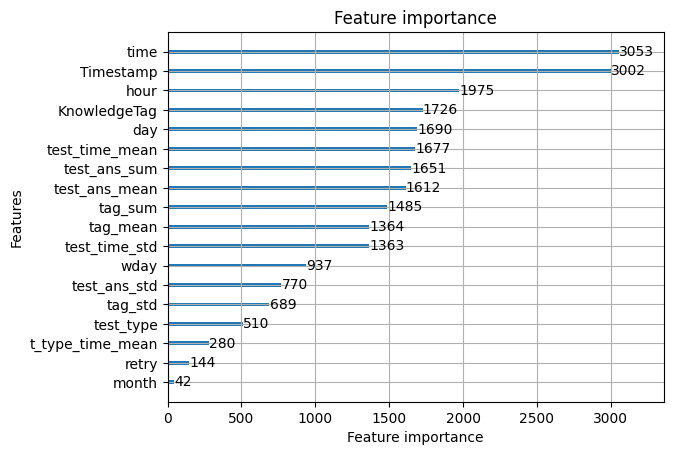

In [77]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [65]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = fe(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [66]:
test_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'Timestamp', 'KnowledgeTag',
       'year', 'month', 'day', 'hour', 'wday', 'retry', 'time', 'time_class',
       'test_ans_mean', 'test_ans_sum', 'test_ans_std', 'test_time_mean',
       'test_time_std', 'test_type', 't_type_ans_mean', 't_type_ans_sum',
       't_type_ans_std', 't_type_time_mean', 't_type_time_std',
       'test_type_lvl', 'tag_mean', 'tag_sum', 'tag_std',
       'user_correct_answer', 'user_total_answer', 'user_acc'],
      dtype='object')

In [67]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])
total_preds.mean()

0.48983511018453524

In [68]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "LGBM_feat_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/LGBM_feat_submission.csv
